In [352]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from operator import itemgetter 

import seaborn as sns
import matplotlib.pyplot as plt

import random


In [353]:
class AutoEncoder(nn.Module):
    def __init__(self, dimensions_list ):
        super(AutoEncoder, self).__init__()

        encoder_layers_list = []
        decoder_layers_list = []

        for index,dim_ in enumerate(dimensions_list):
            if index!=0:
                encoder_layers_list.append(nn.Linear(dimensions_list[index-1],dim_))
                encoder_layers_list.append(nn.ReLU())


        reversed_dimensions_list = sorted(dimensions_list)
        for index,dim_ in enumerate(reversed_dimensions_list):
            if index!=0:
                decoder_layers_list.append(nn.Linear(reversed_dimensions_list[index-1], dim_))
                decoder_layers_list.append(nn.ReLU())
        

        self.encoder = nn.Sequential(*encoder_layers_list)
        self.decoder = nn.Sequential(*decoder_layers_list)
        
    def forward(self, input):
        x = self.encoder(input)
        outputs = self.decoder(x)

        return outputs
    
    def encoder_predict(self, input):
        outputs = self.encoder(input)
        return outputs
    

In [431]:
training_data = pd.read_csv('../train_df_2.csv')
training_data = training_data.drop(['Unnamed: 0'], axis=1)

testing_data = pd.read_csv('../test_df_2.csv')
testing_data = testing_data.drop(['Unnamed: 0'], axis=1)

prediction_horizon = 28
feat_cols = [f'RV{i}' for i in range(prediction_horizon,100 + 1)]
feature_data = training_data[feat_cols]

In [374]:
scaled_data = feature_data.copy()

max_value = feature_data.apply(lambda x: np.max(x), axis=1)

for col in feat_cols:
    scaled_data[col] = scaled_data[col]/max_value

In [375]:
changing_val = len(feature_data.columns)

dim_lst = []
while changing_val>=10:
    dim_lst.append(changing_val)
    changing_val=int(changing_val/1.75)

dim_lst

[73, 41, 23, 13]

In [386]:
total_indexes = list(range(len(feature_data)))

auto_encoder = AutoEncoder( dimensions_list=dim_lst)
optimizer = torch.optim.Adam(auto_encoder.parameters(), lr = 0.001)

batch_size = 30

INPUT_DATA = feature_data
is_scaled = False

for epoch in range(1400):
    sampled_indexes = random.sample(total_indexes, k=batch_size)
    sampled_tensors = torch.tensor(itemgetter(*sampled_indexes)(INPUT_DATA.to_numpy()), dtype= torch.float32)
    pred = auto_encoder(sampled_tensors)
    
    cost = nn.functional.mse_loss(pred, sampled_tensors)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100==0:
        print('epoch:',epoch,' cost:',cost)

epoch: 0  cost: tensor(3918041.7500, grad_fn=<MseLossBackward0>)
epoch: 100  cost: tensor(1666087.7500, grad_fn=<MseLossBackward0>)
epoch: 200  cost: tensor(1117262.7500, grad_fn=<MseLossBackward0>)
epoch: 300  cost: tensor(1244127.8750, grad_fn=<MseLossBackward0>)
epoch: 400  cost: tensor(1190402.8750, grad_fn=<MseLossBackward0>)
epoch: 500  cost: tensor(2841596.7500, grad_fn=<MseLossBackward0>)
epoch: 600  cost: tensor(826574.5000, grad_fn=<MseLossBackward0>)
epoch: 700  cost: tensor(2363622., grad_fn=<MseLossBackward0>)
epoch: 800  cost: tensor(1341528.3750, grad_fn=<MseLossBackward0>)
epoch: 900  cost: tensor(2047830., grad_fn=<MseLossBackward0>)
epoch: 1000  cost: tensor(878410.3750, grad_fn=<MseLossBackward0>)
epoch: 1100  cost: tensor(873876.5625, grad_fn=<MseLossBackward0>)
epoch: 1200  cost: tensor(870729.5000, grad_fn=<MseLossBackward0>)
epoch: 1300  cost: tensor(1736260.3750, grad_fn=<MseLossBackward0>)


In [387]:
input_tensor = torch.tensor(INPUT_DATA.to_numpy(),dtype=torch.float32)
regenerated_tensor = auto_encoder(input_tensor)
output_df = pd.DataFrame( regenerated_tensor.cpu().detach().numpy(), columns=feat_cols)
latent_tensor = auto_encoder.encoder_predict(input_tensor)
latent_array = latent_tensor.cpu().detach().numpy()
latent_df = pd.DataFrame(latent_array)

if is_scaled:
    for col in feat_cols:
        output_df[col] = output_df[col]*max_value


In [390]:
unscaled_latent_df = latent_df.copy()

if is_scaled:
    for col in unscaled_latent_df.columns:
        unscaled_latent_df[col] = unscaled_latent_df[col]*max_value


col_sums = unscaled_latent_df.sum().to_frame().rename(columns={0:'latent_col_sums'})
zero_columns = col_sums[col_sums.latent_col_sums==0].index.to_list()
unscaled_latent_df = unscaled_latent_df.drop(zero_columns, axis=1)
rename_cols = {col: f'latent_{index}' for index ,col in enumerate(unscaled_latent_df.columns)}
unscaled_latent_df =unscaled_latent_df.rename(columns=rename_cols)
unscaled_latent_df

,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10
0,2202.925293,1872.000732,3087.558594,2772.307373,2568.875244,3018.647705,980.133911,0.000000,3339.826416,2886.222900,0.000000
1,2638.447510,2397.917480,3132.703369,3378.812012,2694.437988,3331.814941,1109.828003,0.000000,3710.429443,3227.401611,0.000000
2,2332.731934,2038.505493,2538.221924,2648.061768,2337.536621,2724.354492,986.240845,0.000000,2793.397705,2859.651367,0.000000
3,4285.893066,3881.741943,3640.446289,4457.907227,3710.060791,4386.949707,1715.934204,19.412186,4175.937988,4988.969727,0.000000
4,4114.437988,3574.703369,4184.004395,4385.816406,4019.799561,4594.443848,1752.882202,0.000000,4452.457520,5033.070312,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
423,6291.709473,4458.773438,9262.441406,5874.605469,8290.318359,8280.394531,3095.723633,0.000000,7607.780273,8984.768555,1514.480225
424,4282.720215,3547.303467,5252.660645,4675.943848,4797.241211,5303.937012,1932.116699,0.000000,5217.760254,5542.250977,0.000000
425,5095.153809,4443.961426,5308.062012,5554.011719,4979.959473,5770.429199,2145.141357,0.000000,5751.557129,6241.142578,0.000000
426,3713.855713,2560.141846,6009.673340,3651.049316,5226.558105,5251.449219,1861.549438,0.000000,4960.154785,5506.270996,1044.474487


In [394]:
train_start_dt: pd.Timestamp = pd.to_datetime('2015-07-01')
train_end_dt:pd.Timestamp = pd.to_datetime('2016-08-31')

combined_df = pd.concat([training_data,unscaled_latent_df], axis=1)
training_df = combined_df[(combined_df.arrival_date>=train_start_dt)&(combined_df.arrival_date<=train_end_dt)].copy()
# combined_df.to_csv('train_data_with_latent_feat.csv')

#### applying the autoencoder from training set to extract latent features for the testing data

In [429]:
# applying the autoencoder to extract latent features for the testing data

test_input_tensor = torch.tensor(testing_data[feat_cols].to_numpy(),dtype=torch.float32)
test_regenerated_tensor = auto_encoder(test_input_tensor)
test_output_df = pd.DataFrame( test_regenerated_tensor.cpu().detach().numpy(), columns=feat_cols)
test_latent_tensor = auto_encoder.encoder_predict(test_input_tensor)
test_latent_array = test_latent_tensor.cpu().detach().numpy()
test_latent_df = pd.DataFrame(test_latent_array)


processed_latent_df = test_latent_df.copy()

test_max_value = testing_data[feat_cols].apply(lambda x: np.max(x), axis=1)
if is_scaled:
    for col in processed_latent_df.columns:
        processed_latent_df[col] = processed_latent_df[col]*test_max_value


test_col_sums = processed_latent_df.sum().to_frame().rename(columns={0:'latent_col_sums'})
zero_columns = test_col_sums[test_col_sums.latent_col_sums==0].index.to_list()
processed_latent_df = processed_latent_df.drop(zero_columns, axis=1)
rename_cols = {col: f'latent_{index}' for index ,col in enumerate(processed_latent_df.columns)}
processed_latent_df =processed_latent_df.rename(columns=rename_cols)
processed_latent_df

,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10
0,7741.886719,6384.620117,6238.139160,6076.190918,7056.672363,7229.561035,3266.022705,0.000000,5318.298828,9454.331055,1071.086914
1,4370.201172,3825.118896,3292.873047,3914.075195,3685.453857,4078.959717,1767.586548,0.000000,3364.787354,5111.454102,0.000000
2,5268.017090,4248.669434,5774.320801,5086.869141,5573.895020,5923.151855,2343.474609,0.000000,5385.049316,6699.825684,251.059448
3,4225.973633,3670.907227,2895.483154,3486.761719,3452.489746,3720.164062,1701.814209,33.998241,2797.868408,4913.480957,171.764206
4,7240.182129,6222.871582,4932.797363,5779.988770,5941.795410,6302.744629,2917.033447,33.407284,4598.566406,8474.895508,526.495911
...,...,...,...,...,...,...,...,...,...,...,...
360,9603.367188,8314.057617,10692.811523,10751.981445,9809.163086,11353.055664,4103.007324,0.000000,11533.289062,11883.549805,0.000000
361,7218.937012,5504.242676,9557.505859,7052.603027,8660.186523,9033.290039,3381.239990,0.000000,8471.321289,9843.635742,871.900818
362,2780.387207,2155.534668,3311.680908,2480.902344,3169.708252,3252.383789,1274.763062,0.000000,2828.703125,3708.482910,483.870178
363,1996.469482,1476.988892,2861.048340,2033.508301,2525.595703,2619.890137,958.363586,0.000000,2532.899414,2757.702393,243.357529


In [433]:
test_combined_df = pd.concat([testing_data,processed_latent_df], axis=1)
test_combined_df.to_csv('test_data_with_latent_feat.csv')

#### Plotting the latent space features with the final revenue figure "RV0"

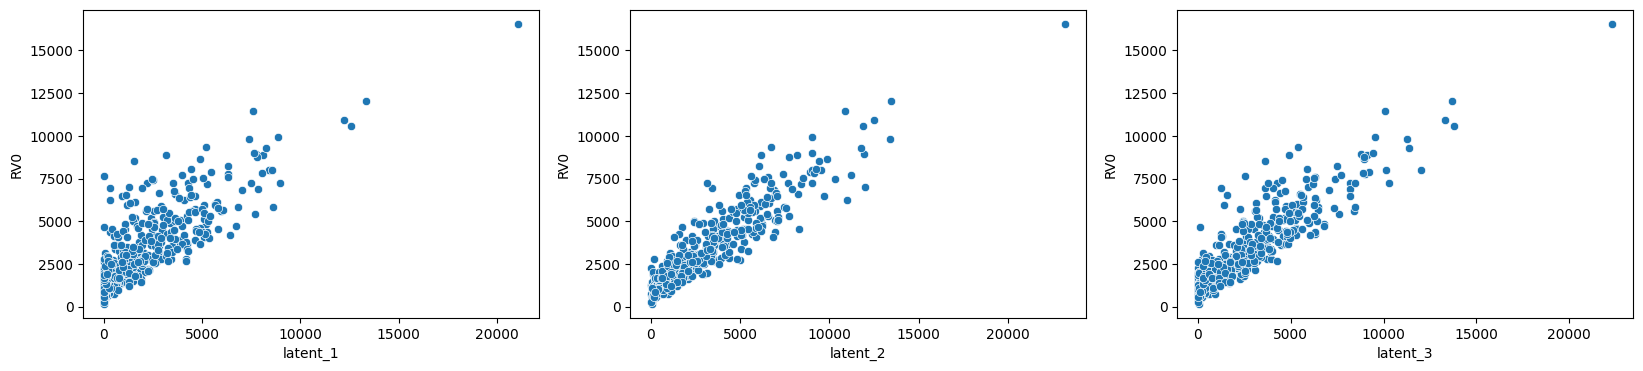

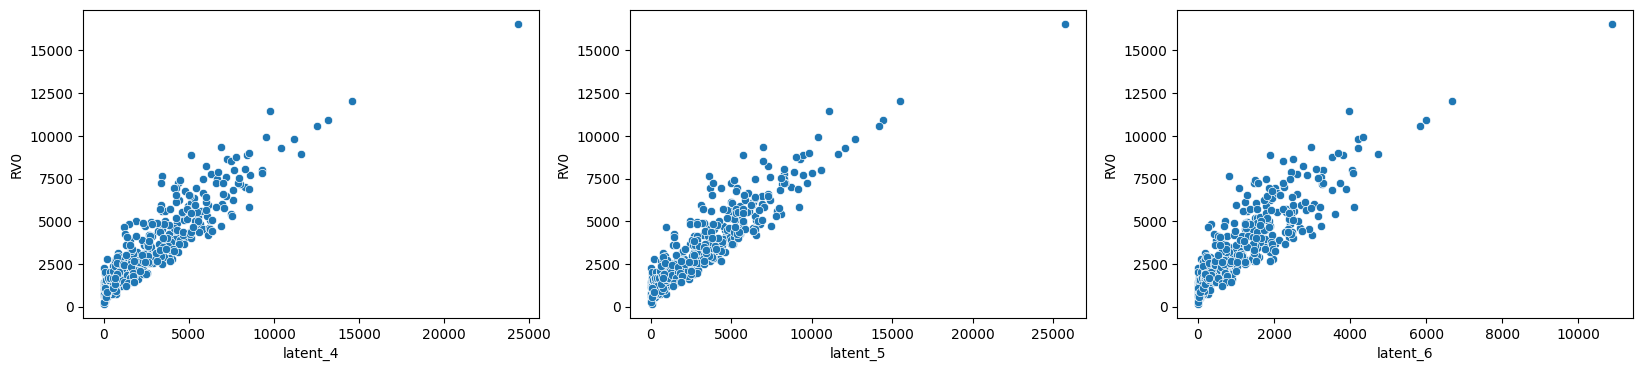

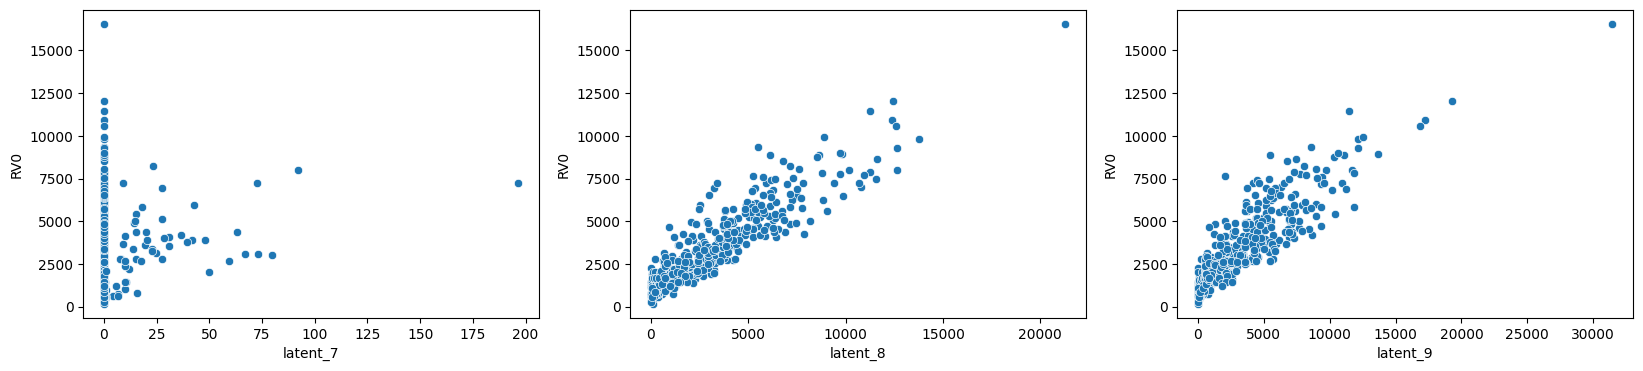

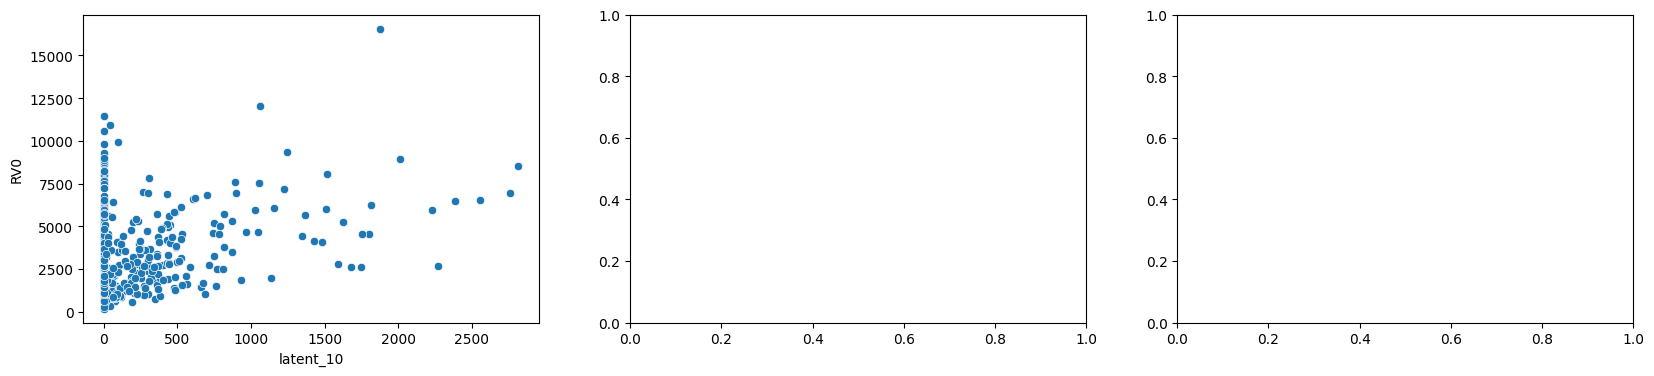

In [415]:
total_plots = len(unscaled_latent_df.columns)
plots_per_row = 3
rows_needed = int(np.ceil(total_plots/plots_per_row))

pointer = 1
different_plots = unscaled_latent_df.columns

for row in range(rows_needed):
    fig,ax = plt.subplots(nrows=1,ncols=plots_per_row, figsize=(20,4))
    for col in range(plots_per_row):
        if pointer<total_plots:
           sns.scatterplot(data=combined_df, y='RV0',x=different_plots[pointer], ax=ax[col])
        pointer+=1